# Tutorial: Using DataSource and Pipeline

> Using `DataSource`, `Pipeline`, and `Transform`s to load the Pets dataset.

In [ ]:
from fastai_local.imports import *
from fastai_local.test import *
from fastai_local.core import *
from fastai_local.data.pipeline import *
from fastai_local.data.source import *
from fastai_local.data.core import *
from fastai.datasets import *

from PIL import Image

Let's see how to use fastai's lower level classes to load the Pets dataset. First, we'll need to grab the dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

We need to create a `Transform` that converts from a single item in `source` to our `x` and `y` for modeling. `setup` will be called once when the `DataSource` is created, so we can use that to create our `vocab` of all possible labels.

In [ ]:
class PetTfm(Transform):
    def __init__(self, source):
        super().__init__()
        self.source,self.vocab = source,None
        self.labeller = re_labeller(pat = r'/([^/]+)_\d+.jpg$')
    
    def setup(self, dsrc):
        vals = map(self.labeller, dsrc.train)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        
    def encodes(self, o):
        # Before `setup` is called we just return the raw item
        if self.vocab is None: return o
        x = Image.open(o).resize((128,128))
        # Convert image to tensor for modeling
        x = tensor(array(x)).float()/255.
        return x.permute(2,0,1), self.o2i[self.labeller(o)]

    def decodes(self, o): return o[0],self.vocab[o[1]]
    def show(self, o, ax=None): show_image(o[0], ax, title=o[1])

We can now create the `PetTfm`, grab the items and split indices, and pass them all to our `DataSource`.

In [ ]:
tfm = PetTfm(source)
items = get_image_files(source)
split_idx = random_splitter()(items)
pets = DataSource(items, tfm, filts=split_idx)

To access an element we need to specify index/filter (the latter defaults to 0 - so this is item 0 of the validation set):

In [ ]:
x,y = pets.get(0,1)
x.shape,y

(torch.Size([3, 128, 128]), 6)

We can also use the `train` and `valid` properties to access the same information.

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index/filt to `decoded`.

In [ ]:
xy = pets.decode((x,y), 1)
xy[1]

'Maine_Coon'

In [ ]:
xy = pets.decoded(0, 1)
test_eq(type(xy[1]),str)

We're now ready to show our items.

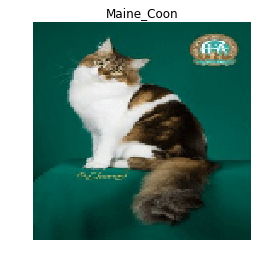

In [ ]:
pets.show((x,y),1)

We can now use this to feed a `DataLoader` and view a batch.

In [ ]:
trn_dl = DataLoader(pets.train,9)
b = next(iter(trn_dl))
bd = pets.decode_batch(b)

In [ ]:
test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (3,128,128))

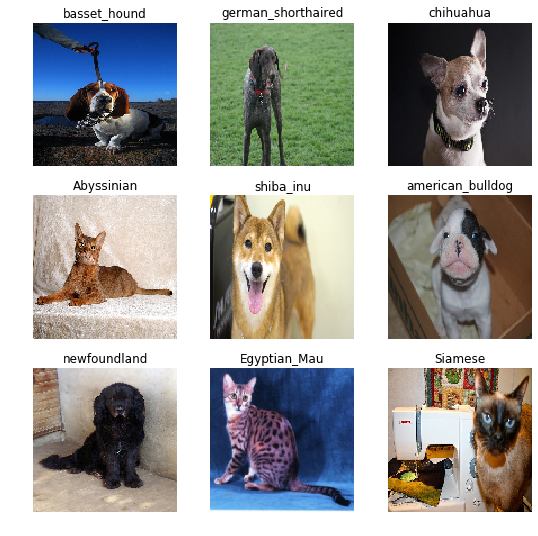

In [ ]:
show_image_batch(bd)

## fin -